In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import shapely
import geopandas as gpd
import salem

import cartopy
import matplotlib.ticker as mticker
import matplotlib.dates as dates
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-1,0], coords_patch[:-1,1], coords_patch[1:,0], coords_patch[1:,1])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
    
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygon
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

### Mean dynamic height

In [3]:
# Load dynamic height to define subpolar gyre region
aviso = xr.open_dataset('/mnt/efs/data/aviso1x1.nc').rename({'LATITUDE':'lat', 'LONGITUDE': 'lon'})

In [4]:
# Define subset around the subpolar gyre
patch_lats = [50, 65, 65, 50]
patch_lons = [-60, -60, -30, -30]

mdt_subset = aviso.MDT.sel(lat=slice(np.min(patch_lats),np.max(patch_lats)),
                           lon=slice(np.min(patch_lons),np.max(patch_lons)))

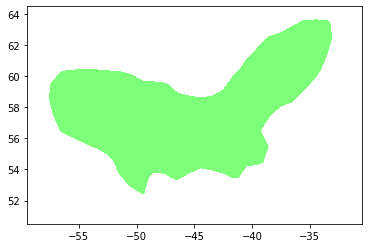

In [5]:
# Set threshold to define subpolar gyre region
mdt_max = -0.56
mdt_patch = mdt_subset.where(mdt_subset<mdt_max)

p0 = plt.contourf(mdt_subset.lon,mdt_subset.lat,np.ma.masked_invalid(mdt_subset),
                  levels=[-0.7,mdt_max],cmap='jet')

In [6]:
# Get contour line of selected area
path = p0.collections[0].get_paths()[0]
v = path.vertices

x0 = v[0,0]
y0 = v[0,1]
count = 0
for (x,y) in v:
    if count >0 and x == x0 and y == y0:
        break;
    #print (count,x,y)
    count += 1

In [7]:
coords_patch = np.loadtxt('/mnt/efs/data/spg_boundary.txt')

In [8]:
gdf_spg = get_gdf_patch(coords_patch)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


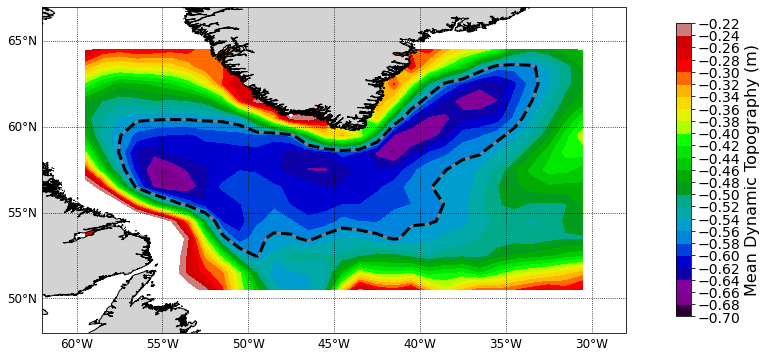

In [9]:
fig = plt.figure(figsize=(18,6))

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-62, -28, 48, 67], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.GSHHSFeature(scale = 'intermediate', edgecolor='k',facecolor='lightgrey'))
gl = ax.gridlines(linestyle=":",color='k', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,5))
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

p = ax.contourf(mdt_subset.lon, mdt_subset.lat,np.ma.masked_invalid(np.clip(mdt_subset,-0.8,0.4)),
                cmap='nipy_spectral',levels=np.arange(-0.7,-0.2,0.02),transform=cartopy.crs.PlateCarree())
ax.contour(mdt_subset.lon, mdt_subset.lat, np.ma.masked_invalid(mdt_subset),
           levels=np.linspace(-0.56,-0.56,1),colors='k',linewidths=3.0)

ax.add_geometries([gdf_spg['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor='grey', 
                  linewidth=2, linestyle='-')

cb = fig.colorbar(p, ticks=np.arange(-0.7,-0.2,0.02), orientation='vertical', shrink=0.9)
cb.set_label(r'Mean Dynamic Topography (m)',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()

### Potential density

In [10]:
en = xr.open_dataset('/mnt/efs/data/hadobs_en4_pden.nc')

In [11]:
en4 = xr.open_dataset('/mnt/efs/data/salinity.nc')

In [12]:
tstart = '1990-01-01'
tend = '2017-12-31'

In [14]:
pden = en.pden.sel(time=slice(tstart,tend),depth=slice(0,2000),
                   lat=slice(np.min(patch_lats),np.max(patch_lats)),
                   lon=slice(np.min(patch_lons),np.max(patch_lons)))

In [15]:
# Load gridded area
a_nc = xr.open_dataset('/mnt/efs/data/hadobs_en4_area.nc')

### Mean profiles

In [16]:
# Create mean profile of sig0: Area-weighted averages of sig0 for each pres
pden_patch = pden.salem.roi(shape=gdf_spg.loc[[0]])

area_spg = ((pden_patch/pden_patch)*a_nc.area).sum(dim=['lat','lon'])
pden_spg = (pden_patch * a_nc.area/area_spg).sum(dim=['lat','lon'])

In [17]:
pden_spg_jan = pden_spg.groupby('time.month').mean('time').sel(month=1)
pden_spg_jul = pden_spg.groupby('time.month').mean('time').sel(month=7)

In [19]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(pden.depth.values)

[5.02159 15.0785 25.1605 35.2783 45.4478 55.6915 66.042 76.5459 87.2703
 98.3112 109.806 121.952 135.029 149.434 165.728 184.697 207.425 235.386
 270.534 315.374 372.965 446.801 540.502 657.323 799.55 967.996 1161.81
 1378.66 1615.29 1868.07]


In [20]:
print('Density between',en4.depth_bnds.sel(depth=slice(0,330))[-1].values[0],'and',
      en4.depth_bnds.sel(depth=slice(0,330))[-1].values[-1],'m','(Depth = ',
      pden.sel(depth=slice(300,320)).squeeze().depth.values,'m)')

Density between 291.5638 and 342.3651 m (Depth =  315.37408 m)


### Repeat analysis for central gyre

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


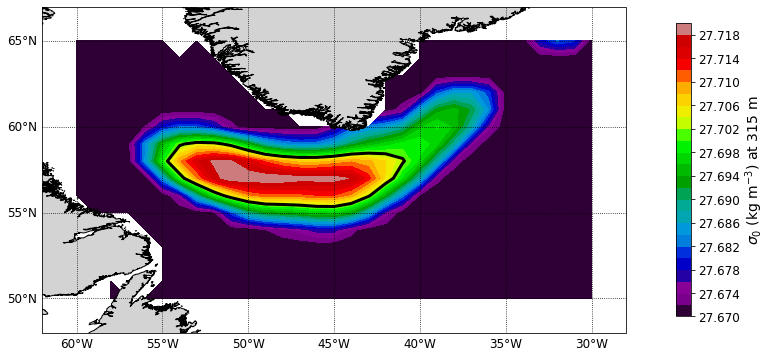

In [21]:
fig = plt.figure(figsize=(18,6))

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-62, -28, 48, 67], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.GSHHSFeature(scale = 'intermediate', edgecolor='k',facecolor='lightgrey'))
gl = ax.gridlines(linestyle=":",color='k', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,5))
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

p = ax.contourf(pden.lon, pden.lat,
                np.ma.masked_invalid(np.clip(pden.sel(depth=slice(300,320)).squeeze().mean('time'),27.67,27.72)),
                cmap='nipy_spectral',levels=np.arange(27.67,27.722,0.002), transform=cartopy.crs.PlateCarree())
ax.contour(pden.lon, pden.lat, np.ma.masked_invalid(pden.sel(depth=slice(300,320)).squeeze().mean('time')),
           levels=np.linspace(27.702,27.702,1),colors='k',linewidths=3.0,
           transform=cartopy.crs.PlateCarree())

cb = fig.colorbar(p, ticks=np.arange(27.67,27.722,0.004), orientation='vertical', shrink=0.9)
cb.set_label(r'$\sigma_0$ (kg m$^{-3}$) at 315 m',fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.show()

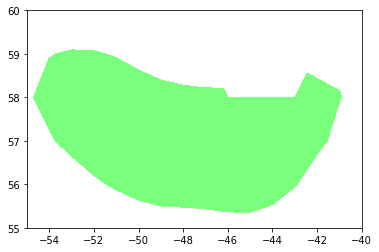

In [22]:
# Set threshold to define central subpolar gyre region with maximal density at pressure 360 dbar
sig_min = 27.702
pden_patch_central = pden_patch.sel(lat=slice(55,60),lon=slice(-55,-40))

p0 = plt.contourf(pden_patch_central.lon,pden_patch_central.lat,
                  np.ma.masked_invalid(pden_patch_central.sel(depth=slice(300,320)).squeeze().mean('time')),
                  levels=[sig_min,28],cmap='jet')
# Get contour line of selected area
path = p0.collections[0].get_paths()[0]
v = path.vertices

x0 = v[0,0]
y0 = v[0,1]
count = 0
for (x,y) in v:
    if count >0 and x == x0 and y == y0:
        break;
    #print (count,x,y)
    count += 1

In [23]:
np.savetxt('/mnt/efs/data/en4_cspg_boundary.txt', v[0:count])

In [24]:
coords_patch = np.loadtxt('/mnt/efs/data/en4_cspg_boundary.txt')

In [25]:
gdf_cspg = get_gdf_patch(coords_patch)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [26]:
# Create mean profile 
pden_patch_cspg = pden_patch.sel(lat=slice(55,60),lon=slice(-50,-40))
pden_patch_cspg_max = pden_patch_cspg.where(pden_patch_cspg.sel(depth=slice(300,320)).squeeze().mean('time')>=sig_min)

area_cspg_max = ((pden_patch_cspg_max/pden_patch_cspg_max)*a_nc.area).sum(dim=['lat','lon'])
pden_cspg_max = (pden_patch_cspg_max * a_nc.area/area_cspg_max).sum(dim=['lat','lon'])

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
pden_cspg_max_jan = pden_cspg_max.groupby('time.month').mean('time').sel(month=1)
pden_cspg_max_jul = pden_cspg_max.groupby('time.month').mean('time').sel(month=7)

In [28]:
print('Density between',en4.depth_bnds.sel(depth=slice(0,400))[-1].values[0],'and',
      en4.depth_bnds.sel(depth=slice(0,400))[-1].values[-1],'m','(Depth = ',
      pden.sel(depth=slice(350,400)).squeeze().depth.values,'m)')

Density between 342.3651 and 407.6244 m (Depth =  372.96545 m)


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


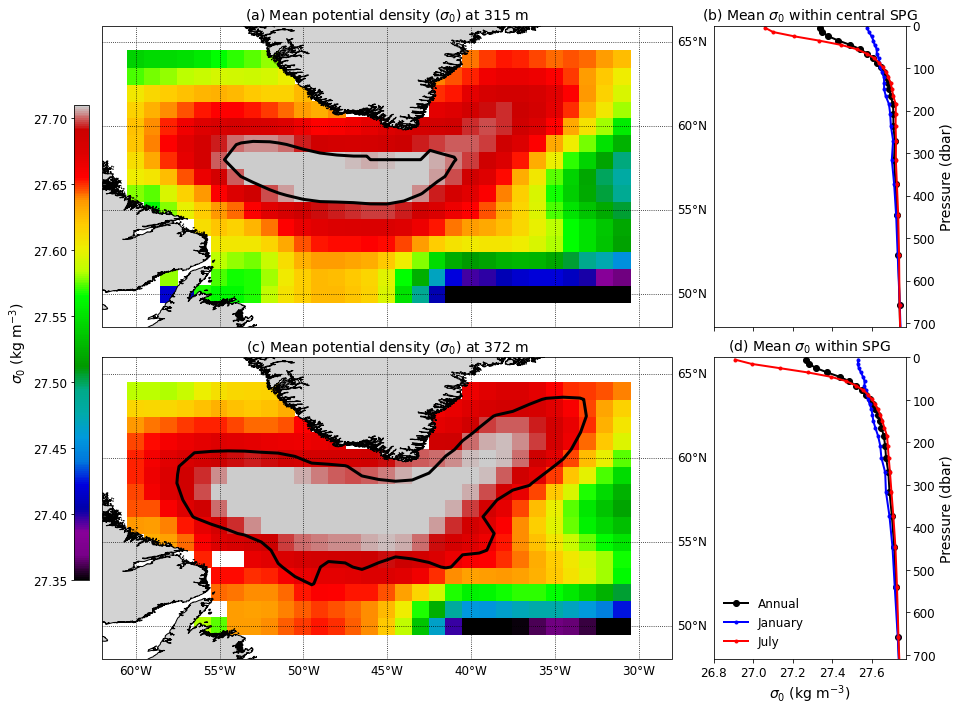

In [29]:
fig = plt.figure(figsize=(14, 11))

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.1)
gs = gridspec.GridSpec(2, 2, height_ratios =[1,1], width_ratios=[7.5, 2.5]) 

ax11 = plt.subplot(gs[0,0], projection=cartopy.crs.PlateCarree())
ax11.set_title(r'(a) Mean potential density ($\sigma_0$) at 315 m',fontsize=14)
ax11.set_extent([-62, -28, 48, 66], cartopy.crs.PlateCarree())
ax11.add_feature(cartopy.feature.GSHHSFeature(scale = 'intermediate', edgecolor='k',facecolor='lightgrey'))
gl = ax11.gridlines(linestyle=":",color='k', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,5))
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False

gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

p = ax11.pcolormesh(pden.lon-0.5,pden.lat-0.5,
                    np.ma.masked_invalid(pden.sel(depth=slice(300,320)).squeeze().mean('time')),
                    cmap='nipy_spectral', vmin=27.35, vmax=27.71, transform=cartopy.crs.PlateCarree())
ax11.add_geometries([gdf_cspg['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1),
                    linewidth=3, linestyle='-')

ax12 = plt.subplot(gs[0,1])
ax12.set_title(r'(b) Mean $\sigma_0$ within central SPG',fontsize=14)
ax12.plot(pden_cspg_max.mean('time'),pden_cspg_max.depth,color='k',marker='o',markersize=6,linewidth=2,label='Annual')
ax12.plot(pden_cspg_max_jan, pden_cspg_max_jan.depth, color='b',marker='.',linewidth=2,label='January')
ax12.plot(pden_cspg_max_jul, pden_cspg_max_jul.depth, color='r',marker='.',linewidth=2,label='July')

ax12.set_ylabel('Pressure (dbar)',fontsize=14)
#ax12.set_yticks(sig0.pres)
ax12.set_xlim([26.8,27.77])
ax12.set_ylim([0,710])
#ax12.set_ylim([0,410])
ax12.invert_yaxis()
ax12.yaxis.set_label_position('right')
ax12.yaxis.tick_right()
ax12.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax12.set_xticklabels([])

ax21 = plt.subplot(gs[1,0], projection=cartopy.crs.PlateCarree())
ax21.set_title(r'(c) Mean potential density ($\sigma_0$) at 372 m',fontsize=14)
ax21.set_extent([-62, -28, 48, 66], cartopy.crs.PlateCarree())
ax21.add_feature(cartopy.feature.GSHHSFeature(scale = 'intermediate', edgecolor='k',facecolor='lightgrey'))
gl = ax21.gridlines(linestyle=":",color='k', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,5))
gl.top_labels = False
gl.left_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

p = ax21.pcolormesh(pden.lon-0.5,pden.lat-0.5,
                    np.ma.masked_invalid(pden.sel(depth=slice(350,400)).squeeze().mean('time')),
                    cmap='nipy_spectral', vmin=27.35, vmax=27.71, transform=cartopy.crs.PlateCarree())
ax21.add_geometries([gdf_spg['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                    linewidth=3, linestyle='-')

cax = fig.add_axes([0.075, 0.20, 0.015, 0.6])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.9, ticks=np.arange(27.35,27.75,0.05))
cb.set_label(r'$\sigma_0$ (kg m$^{-3}$)',fontsize=14)
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
cb.ax.tick_params(labelsize=12)

ax22 = plt.subplot(gs[1,1])
ax22.set_title(r'(d) Mean $\sigma_0$ within SPG',fontsize=14)
ax22.plot(pden_spg.mean('time'),pden_spg.depth,color='k',marker='o',markersize=6,linewidth=2,label='Annual')
ax22.plot(pden_spg_jan, pden_spg_jan.depth, color='b',marker='.',linewidth=2,label='January')
ax22.plot(pden_spg_jul, pden_spg_jul.depth, color='r',marker='.',linewidth=2,label='July')
ax22.set_xlabel(r'$\sigma_0$ (kg m$^{-3}$)',fontsize=14)
ax22.set_ylabel('Pressure (dbar)',fontsize=14)
#ax22.set_yticks(sig0.pres)
ax22.set_xlim([26.8,27.77])
ax22.set_ylim([0,710])
#ax22.set_ylim([0,410])
ax22.invert_yaxis()
ax22.yaxis.set_label_position('right')
ax22.yaxis.tick_right()
ax22.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax22.legend(loc='lower left',frameon=False,fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps', rasterized=True, dpi=300)
plt.show()

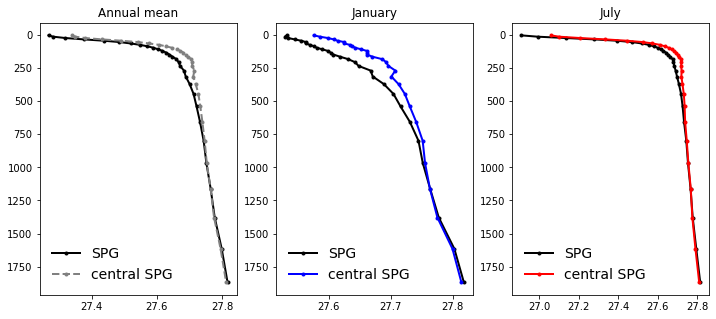

In [30]:
f, ax = plt.subplots(1,3, figsize=(12,5))

plt.subplot(1,3,1)
plt.plot(pden_spg.mean('time'),pden_spg.depth,color='k',marker='.',markersize=6,linewidth=2,label='SPG')
plt.plot(pden_cspg_max.mean('time'),pden_cspg_max.depth, color='grey',marker='.',markersize=6,linewidth=2,
         linestyle='--',label='central SPG')
plt.gca().invert_yaxis()
plt.title('Annual mean')
plt.legend(loc='lower left',frameon=False,fontsize=14)

plt.subplot(1,3,2)
plt.plot(pden_spg_jan,pden_spg_jan.depth,color='k',marker='.',linewidth=2,label='SPG')
plt.plot(pden_cspg_max_jan,pden_cspg_max_jan.depth,color='b',marker='.',linewidth=2,label='central SPG')
plt.gca().invert_yaxis()
plt.title('January')
plt.legend(loc='lower left',frameon=False,fontsize=14)

plt.subplot(1,3,3)
plt.plot(pden_spg_jul,pden_spg_jul.depth,color='k',marker='.',linewidth=2,label='SPG')
plt.plot(pden_cspg_max_jul,pden_cspg_max_jul.depth,color='r',marker='.',linewidth=2,label='central SPG')
plt.gca().invert_yaxis()
plt.title('July')
plt.legend(loc='lower left',frameon=False,fontsize=14)

plt.show()

### Mean density at 315 m

In [36]:
area_spg = ((pden_patch/pden_patch)*a_nc.area).sum(dim=['lat','lon'])

# Spatial mean density of subpolar gyre
pden_spg = ((pden_patch.sel(depth=slice(300,320)).squeeze()*a_nc.area)/\
            area_spg.sel(depth=slice(300,320)).squeeze()).sum(dim=['lat','lon'])

In [40]:
area_cspg = ((pden_patch_cspg_max/pden_patch_cspg_max)*a_nc.area).sum(dim=['lat','lon'])

# Spatial mean density of central subpolar gyre
pden_cspg = ((pden_patch_cspg_max.sel(depth=slice(300,320)).squeeze()*a_nc.area)/\
             area_cspg.sel(depth=slice(300,320)).squeeze()).sum(dim=['lat','lon'])

In [ ]:
sig['year'] = pd.DatetimeIndex(sig.time).year
sig_ann = sig[['year','sigma_cspg_300_mean']].groupby(['year']).mean()
sigma_mean_300 = sig_ann.to_xarray().sigma_cspg_300_mean

### Save sigma time series to dataframe

In [43]:
# Convert to dataframe
df = pden_spg.to_dataframe(name='sigma_spg').reset_index()
df.time = pd.DatetimeIndex(df.time)
df['sigma_cspg'] = pden_cspg

df = df.drop('depth', 1)
df = df.set_index(['time'])

In [44]:
df

,sigma_spg,sigma_cspg
time,,
1990-01-14,27.643241,27.665877
1990-02-14,27.686177,27.705409
1990-03-14,27.698966,27.716424
1990-04-15,27.725572,27.739365
1990-05-15,27.715337,27.730926
...,...,...
2017-08-15,27.725855,27.748011
2017-09-15,27.712696,27.727532
2017-10-15,27.707077,27.722093


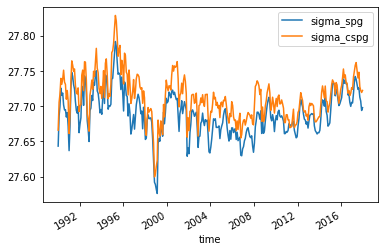

In [45]:
df.plot()

In [46]:
df.to_csv('/mnt/efs/data/en4_sigma.csv', index=True)